In [6]:
import torch
from datetime import datetime
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


torch.manual_seed(42) # To ensure sanity
print(device)

cpu


In [7]:
cwd = Path.cwd()
cut_folder = cwd / "Field Cut Data" / "cut_files"
log_folder = cwd / "Field Cut Data" / "log_files"
print(cwd)

C:\Users\Niels\Documents\GitHub\Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction\Prelimary Data Analysis


-45.0 0.09 1001.0 0.0 3.0 1.0 2.0
(4, 1001)


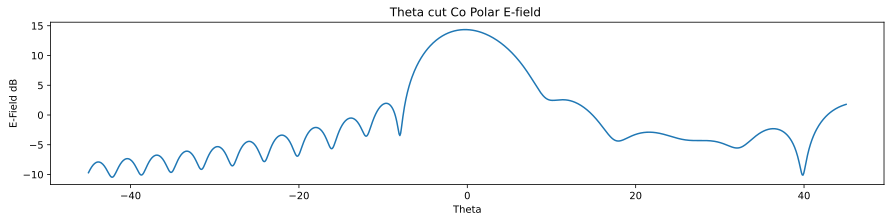

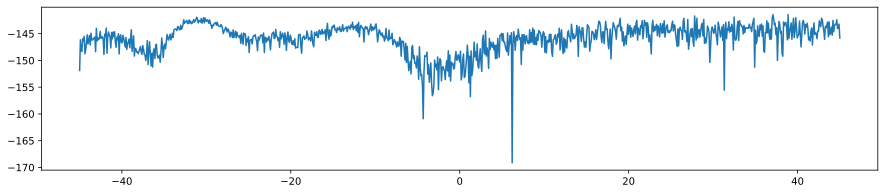

In [9]:
file_to_open = cut_folder / "1001.cut"
V_INI, V_INC, V_NUM, C, ICOMP, ICUT, NCOMP = np.genfromtxt(file_to_open, max_rows=1, skip_header=1)
print(V_INI, V_INC, V_NUM, C, ICOMP, ICUT, NCOMP)
data = np.genfromtxt(file_to_open, skip_header=2,dtype = np.float32).T
print(data.shape)


thetas = np.linspace(-45.0, 45.0, int(V_NUM))
copolar = np.sqrt(data[0]**2 + data[1]**2)
xpolar = np.sqrt(data[2]**2 + data[3]**2)
copolar_dB = 10*np.log10(copolar)
xpolar_dB = 10*np.log10(xpolar)
plt.figure(figsize=(15,3))
plt.plot(thetas, copolar_dB)
plt.title('Theta cut Co Polar E-field ')
plt.xlabel('Theta')
plt.ylabel('E-Field dB')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(thetas, xpolar_dB)
plt.show()


# Experimentation with feed forward models overfitting

Here we are exprimenting with overfitting a single cut of the E field of an antenna, and looking at what we can learn from this. 


## 1. mapping of antenna parameters directly to subspace of electric field

$$\chi \rightarrow \boldsymbol{E}$$

In [11]:
## Common hyperparameters
LEARNING_RATE = 1e-5;
EPOCHS = int(1e5);

print(np.mean(copolar))

3.2566023


In [12]:

criterion = torch.nn.MSELoss() # Mean squared error


NN = 100;
class FullSpaceNet(nn.Module):
    def __init__(self):
        super(FullSpaceNet, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(3, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, int(V_NUM)))
        
    def forward(self, x):
        output = self.regressor(x)
        return output

    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(np.mean(copolar))
        
        
        
## Make forward pass
fullSpaceNet = FullSpaceNet()
fullSpaceNet.apply(init_weights)
t_data = torch.Tensor([+4.1666666667E-02,5.7777777778E-01,0.0000000000E+00])
print(fullSpaceNet(t_data))

loss = criterion(input = fullSpaceNet(t_data), target = torch.from_numpy(copolar_dB))
print(loss)





EPOCHS = int(4e5)

startTime = datetime.now()
optimizer = torch.optim.AdamW(fullSpaceNet.parameters(),lr = LEARNING_RATE)
loss_array = []
for epoch in range(EPOCHS):
    
    out = fullSpaceNet(t_data)
    
    loss = criterion(input = out, target = torch.from_numpy(copolar))
    #Gradients
    loss.backward()
    loss_array.append(loss.detach().numpy())
    #Step Optimizer
    optimizer.step()
    if epoch%(EPOCHS/10) == 0:
        print(loss)

print('Training time:', datetime.now()-startTime)


tensor([3.6497, 3.0700, 3.9810,  ..., 3.4356, 2.7139, 3.2088],
       grad_fn=<AddBackward0>)
tensor(64.1161, grad_fn=<MseLossBackward>)
tensor(46.5856, grad_fn=<MseLossBackward>)
tensor(16.2267, grad_fn=<MseLossBackward>)
tensor(7.7849, grad_fn=<MseLossBackward>)
tensor(1.8132, grad_fn=<MseLossBackward>)
tensor(1.6927, grad_fn=<MseLossBackward>)
tensor(0.3809, grad_fn=<MseLossBackward>)
tensor(0.1004, grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

In [13]:
print('Training time', datetime.now()-startTime)

Training time 0:07:40.484739


C:\Users\Niels\AppData\Local\Temp/ipykernel_18824/1135678711.py:10: RuntimeWarning: invalid value encountered in log10
  plt.plot(thetas,10*np.log10(fullSpaceNet(t_data).detach().numpy()))


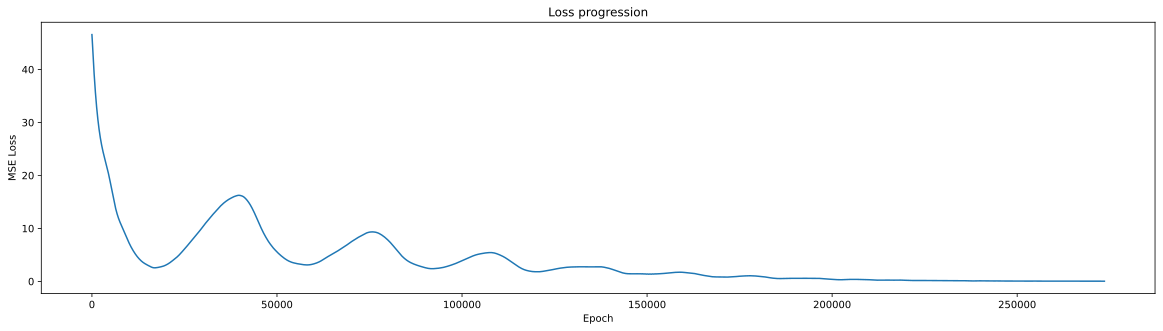

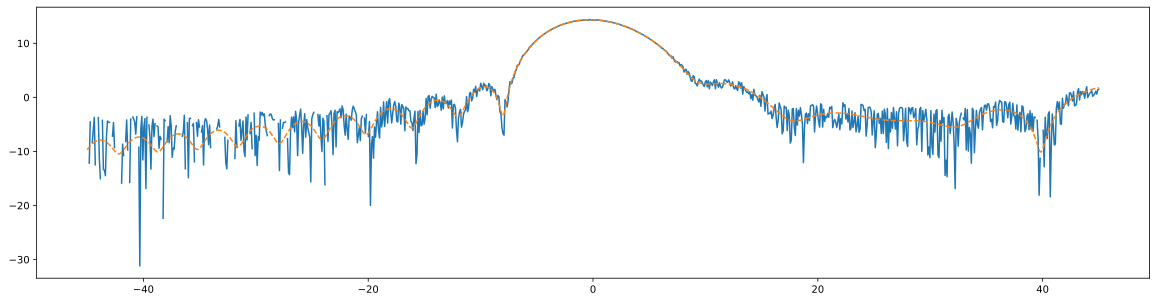

In [15]:
plt.figure(figsize = (20,5))
plt.plot(loss_array)
plt.title('Loss progression')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')



plt.figure(figsize = (20,5))
plt.plot(thetas,10*np.log10(fullSpaceNet(t_data).detach().numpy()))
plt.plot(thetas,copolar_dB,label = 'Target',linestyle = '--')

#plt.plot(thetas,net(t_data).detach().numpy()-copolar_dB)

## Mapping single output with theta being a parameter

In [ ]:
NN = 100;
class SingleThetaNet(nn.Module):
    def __init__(self):
        super(SingleThetaNet, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(4, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, 1))
        
    def forward(self, x):
        output = self.regressor(x)
        return output

    
## Make forward pass
singleThetaNet = SingleThetaNet()
singleThetaNet.apply(init_weights)

parameters = torch.Tensor([[+4.1666666667E-02,5.7777777778E-01,0.0000000000E+00, theta] for theta in thetas])

## Test forward pass
print(singleThetaNet(parameters))

In [ ]:


startTime = datetime.now()
criterion = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.AdamW(singleThetaNet.parameters(),lr = LEARNING_RATE)
copolar_dB_torch = torch.reshape(torch.from_numpy(copolar_dB), (1001,1))
loss_array = []
for epoch in range(EPOCHS):
    
    out = singleThetaNet(parameters)
    
    loss = criterion(input = out, target = copolar_dB_torch)
    #Gradients
    loss.backward()
    loss_array.append(loss.detach().numpy())
    #Step Optimizer
    optimizer.step()
    if epoch%(EPOCHS/10) == 0:
        print(loss)

print('Training time:', datetime.now()-startTime)

In [ ]:
       
plt.figure(figsize = (20,5))
plt.plot(loss_array)
plt.title('Loss progression')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

In [ ]:
        
netOutput = singleThetaNet(parameters).detach().numpy().flatten()
print(netOutput)

plt.figure(figsize = (20,5))
plt.plot(thetas,netOutput,label = 'Output from net')
plt.plot(thetas,copolar_dB,label = 'Target',linestyle = '--')
#plt.plot(thetas,netOutput-copolar_dB,label = 'Net error')
plt.legend()

# Easier to estimate coefficients of FFT?

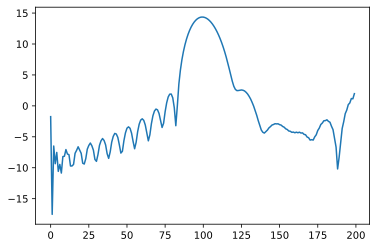

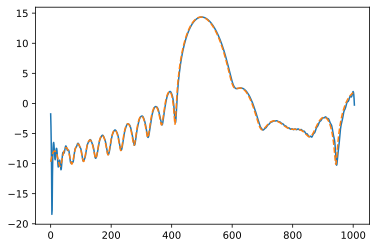

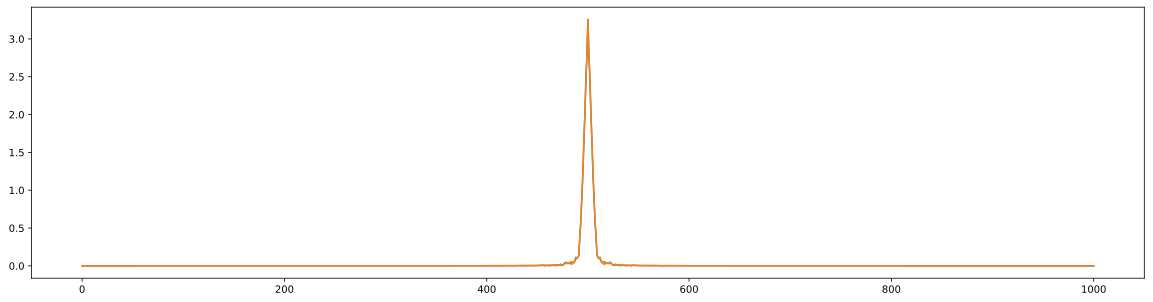

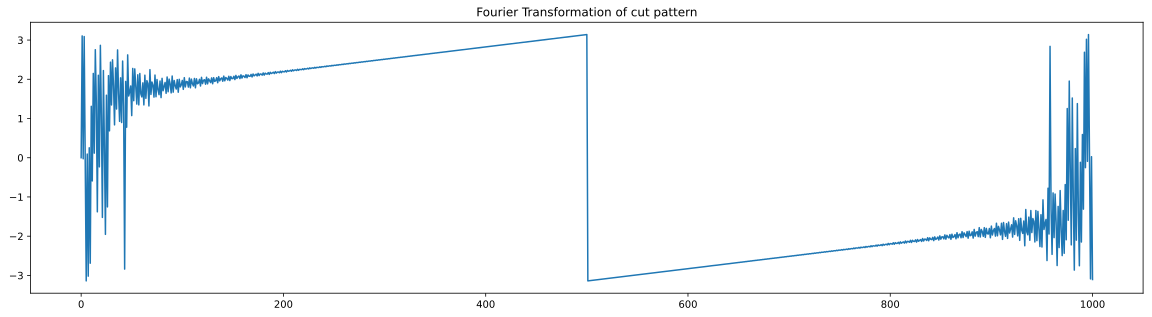

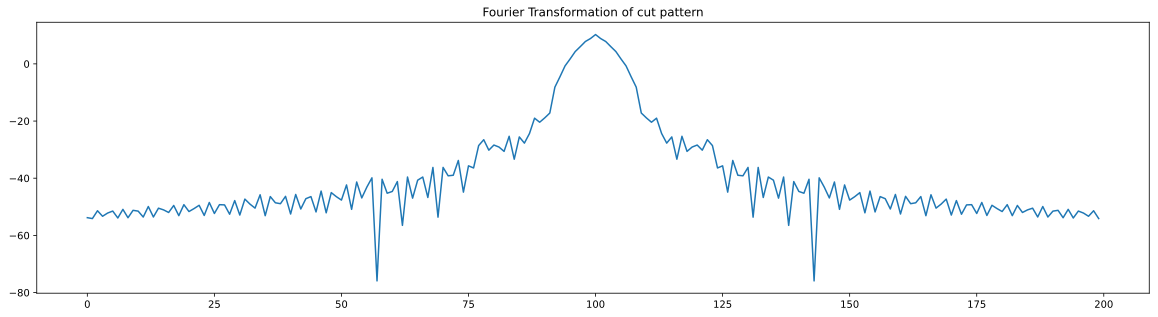

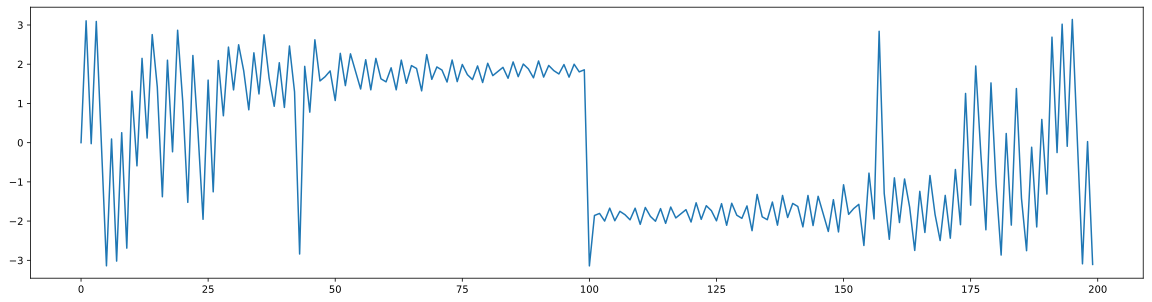

In [28]:



from scipy.fft import fft, ifft
from scipy import signal


copolar_downsample=signal.resample(copolar,200)

y = fft(copolar_downsample)
x_ifft = ifft(y)

plt.figure()
plt.plot(10*np.log10(copolar_downsample))


plt.figure()
plt.plot(10*np.log10(signal.resample(copolar_downsample,1005)))
plt.plot(10*np.log10(copolar),linestyle = '--')


plt.figure(figsize = (20,5))
plt.plot(abs(np.roll(fft(copolar),len(copolar)//2))/len(copolar))
plt.plot(abs(np.roll(fft(copolar),len(copolar)//2))/len(copolar))

plt.figure(figsize = (20,5))
plt.plot(np.angle(fft(copolar)))
plt.title('Fourier Transformation of cut pattern')
plt.figure(figsize = (20,5))
plt.plot(20*np.log10(abs(np.roll(y,len(y)//2))/len(copolar_downsample)))
plt.title('Fourier Transformation of cut pattern')

plt.figure(figsize = (20,5))
plt.plot(np.angle(y))

NN = 100;
class FFTNet(nn.Module):
    def __init__(self):
        super(FFTNet, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(3, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, int(V_NUM)))
        
    def forward(self, x):
        output = self.regressor(x)
        return output

    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(np.mean(copolar_dB))






# Make single cut dataset and dataloader

In [289]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


class SingleCutDataset(Dataset):
    """Field Cut dataset"""

    def __init__(self, cut_dir, param_dir,cut,normalise = False):
        """
        Args:
            data_file (Path Object): File Location of cut data 
            param_dir (Path Object): Parameter file location
            cut (integer) : Integer name of file in directory
        """
        
        cut_file = cut_dir / (str(cut)+'.cut')
        param_file = param_dir / 'lookup.log'
        
        
        V_INI, V_INC, V_NUM, C, ICOMP, ICUT, NCOMP = np.genfromtxt(cut_file, max_rows=1, skip_header=1)
        thetas = torch.linspace(V_INI,V_INI+V_INC*(V_NUM-1),int(V_NUM))
        self.field_cut = torch.from_numpy(np.genfromtxt(cut_file, skip_header=2,dtype = np.float32).T)

        
        
        antenna_parameters = np.genfromtxt(param_file, skip_header=1,dtype = np.float32).T
        #antenna_parameters = antenna_parameters[:,cut]
        
        self.parameters = torch.Tensor([np.append(antenna_parameters[1:,cut],theta) for theta in thetas])
        
    def __len__(self):
        return self.field_cut.shape[1]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        parameters = self.parameters[idx,:]
        field_val = self.field_cut[:,idx]
        
            
        return parameters, field_val
    
    def getMean(self):
        return (self.parameterMean, self.fieldMean)
        
    def getStd(self):
        return (self.parameterStd, self.fieldStd)




In [301]:
dataset = SingleCutDataset(cut_folder,log_folder,0)

trainloader = DataLoader(dataset,batch_size=1001, shuffle=True)

for params,field in trainloader:
    print(params.shape)
    


m = nn.BatchNorm1d(4, affine=False)
input = torch.randn(100, 4)
output = m(params)
print(params)
print(output)


torch.Size([1001, 4])
tensor([[ 1.0000e-02,  4.0000e-01,  0.0000e+00, -3.0600e+00],
        [ 1.0000e-02,  4.0000e-01,  0.0000e+00, -5.8500e+00],
        [ 1.0000e-02,  4.0000e-01,  0.0000e+00, -1.5750e+01],
        ...,
        [ 1.0000e-02,  4.0000e-01,  0.0000e+00, -1.0170e+01],
        [ 1.0000e-02,  4.0000e-01,  0.0000e+00, -3.4830e+01],
        [ 1.0000e-02,  4.0000e-01,  0.0000e+00, -3.8430e+01]])
tensor([[ 0.0000,  0.0000,  0.0000, -0.1177],
        [ 0.0000,  0.0000,  0.0000, -0.2249],
        [ 0.0000,  0.0000,  0.0000, -0.6056],
        ...,
        [ 0.0000,  0.0000,  0.0000, -0.3911],
        [ 0.0000,  0.0000,  0.0000, -1.3393],
        [ 0.0000,  0.0000,  0.0000, -1.4777]])


In [370]:
from torch.utils.data import random_split
print(len(dataset))
testSplit,trainSplit = (0.2,0.8)
trainSet,testSet = random_split(dataset,[len(dataset)*trainSplit,len(dataset)*testSplit])

trainLoader = DataLoader(trainSet,batch_size = 10,shuffle = True)
testLoader = DataLoader(testSet, batch_size = 10,shuffle = True)

for param,field in testSet:
    print(param)


1001


ValueError: Sum of input lengths does not equal the length of the input dataset!

In [346]:
NN = 10;
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.regressor = nn.Sequential(nn.BatchNorm1d(4),
                                       nn.Linear(4, NN),
                                       nn.ReLU(),
                                       nn.Linear(NN, NN),
                                       nn.ReLU(),
                                       nn.Linear(NN, NN),
                                       nn.ReLU(),
                                       nn.Linear(NN, 4))
        
    def forward(self, x):
        output = self.regressor(x)
        return output

    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)
        


net = Net()
net.apply(init_weights)
net(torch.randn(2,4))

tensor([[ 0.0185, -0.0088, -0.0049,  0.0352],
        [ 0.1455,  0.1955, -0.2124,  0.1307]], grad_fn=<AddmmBackward>)

In [349]:

EPOCHS = int(1e3)
LEARNING_RATE = 1e-3


optimizer = torch.optim.Adam(net.parameters(),lr = LEARNING_RATE)
loss_array = []
for epoch in range(EPOCHS):
    
    train_loss = 0
    for param, field in trainloader:
        
        out = net(param)

        loss = criterion(input = out, target = field)
        #Gradients
        train_loss = train_loss + loss
        loss.backward()
        loss_array.append(loss.detach().numpy())
        #Step Optimizer
        optimizer.step()
        
        
    if epoch%(EPOCHS/10) == 0:
        print(torch.mean(train_loss))

print('Training time:', datetime.now()-startTime)





tensor(16.5414, grad_fn=<MeanBackward0>)
tensor(16.6007, grad_fn=<MeanBackward0>)
tensor(16.4710, grad_fn=<MeanBackward0>)
tensor(16.3356, grad_fn=<MeanBackward0>)
tensor(16.1927, grad_fn=<MeanBackward0>)
tensor(16.0264, grad_fn=<MeanBackward0>)
tensor(15.8268, grad_fn=<MeanBackward0>)
tensor(15.5949, grad_fn=<MeanBackward0>)
tensor(15.3354, grad_fn=<MeanBackward0>)
tensor(15.0570, grad_fn=<MeanBackward0>)
Training time: 5 days, 6:17:49.850491


In [ ]:
plt.figure()
plt.semilogy(loss_array)


tensor([-1.5420e-16,  8.8849e-17,  4.2709e-17,  ..., -1.5737e-16,
         1.6364e-16,  1.6892e-17])
tensor([ 0.3900,  0.2455,  1.7400,  ..., -0.1859, -0.1359, -0.1588],
       grad_fn=<SelectBackward>)
tensor([ -5.1300,   3.6900, -35.2800,  ...,  19.5300,  40.5000,  30.8700])


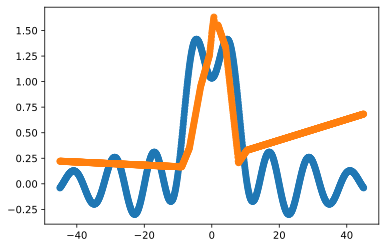

In [341]:
for param, field in trainloader:
    print(field[:,2])
    print(net(param)[:,2])
    print(param[:,3])
    

    
plt.scatter(param[:,3],field[:,0])
plt.scatter(param[:,3],net(param)[:,0].detach().numpy())